In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd
import random
from pyvbmc import VBMC

from post_LED_censor_utils import rho_A_t_fn, cum_A_t_fn, CDF_rho_times_P_x_t_fn, CDF_v_change_till_stim_trunc_adj_fn, PDF_t_v_change
from scipy.integrate import trapezoid as trapz
from post_LED_fit_utils import d_A_RT_SCALAR, stupid_f_integral_SCALAR, PA_with_LEDON_2_SCALAR, d_A_RT_VEC, stupid_f_integral_VEC, PA_with_LEDON_2_VEC

# data

In [2]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# drop rows from df where intended_fix, LED_onset_time and timed_fix are nan
df = df.dropna(subset=['intended_fix', 'LED_onset_time', 'timed_fix'])
tuple_column = list(zip(df['intended_fix'], df['intended_fix'] - df['LED_onset_time']))

In [23]:
df_led_on = df[df['LED_trial'] == 1]
df_led_on = df_led_on[(df_led_on['abort_event'] == 3) | (df_led_on['success'].isin([1,-1]))]
print(f'len(df_led_on) = {len(df_led_on)}')

len(df_led_on) = 30910


# likelihood

In [24]:
T_trunc = 0.3

In [25]:
V_A = 1.59
theta_A = 2.53
# total proactive delay
total_proactive_delay = -0.187

In [26]:
t_pts_for_trunc = np.arange(0, T_trunc, 0.001)
def compute_loglike(row, post_LED_drift, motor_delay):
    delta_i = total_proactive_delay - motor_delay
    tfix = 0

    rt = row['timed_fix']
    t_stim = row['intended_fix']
    t_LED = row['intended_fix'] - row['LED_onset_time']

    # truncation factor
    PA_vec = PA_with_LEDON_2_VEC(t_pts_for_trunc, V_A, post_LED_drift, theta_A, tfix, t_LED, delta_i, motor_delay)
    trunc_factor = 1 - trapz(PA_vec, t_pts_for_trunc)
    
    if rt < T_trunc:
        likelihood = 0
    else:
        if rt <= t_stim: # abort
            if rt - motor_delay - t_LED < 0: 
                # RT - motor - t_LED < 0 => time travelled with V2 is negative, which is not possible
                # Remedy 1: likelihood = 0
                # likelihood = 0

                # Remedy 2: Assume it hit with a single drift only
                v = V_A
                a = theta_A
                likelihood = d_A_RT_SCALAR(v * a, (rt - (delta_i + motor_delay) + tfix) / (a**2)) / (a**2)
            else:
                likelihood = PA_with_LEDON_2_SCALAR(rt, V_A, post_LED_drift, theta_A, tfix, t_LED, delta_i, motor_delay)
        else: # valid trial
            # censored likelihood after t_stim
            t_pts_for_censor = np.arange(t_stim, 5, 0.005)
            PA_after_tstim = PA_with_LEDON_2_VEC(t_pts_for_censor, V_A, post_LED_drift, theta_A, tfix, t_LED, delta_i, motor_delay)
            CDF_after_tstim = trapz(PA_after_tstim, t_pts_for_censor)
            likelihood = CDF_after_tstim


    likelihood /= trunc_factor
            
                

    if likelihood <= 0:
        likelihood = 1e-50
    
    return np.log(likelihood)
    

def vbmc_loglike_fn(params):
    post_LED_drift, motor_delay = params

    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike)(row, post_LED_drift, motor_delay)\
                                      for _, row in df_led_on.iterrows())
    
    return np.sum(all_loglike)
   

# bounds

In [27]:
post_LED_drift_bounds = [1, 10]
post_LED_drift_plausible_bounds = [1.5, 3.5]

motor_delay_bounds = [0, 0.1]
motor_delay_plausible_bounds = [0.01, 0.07]

# prior

In [28]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    post_LED_drift, motor_delay = params

    post_LED_drift_logpdf = trapezoidal_logpdf(post_LED_drift, post_LED_drift_bounds[0], post_LED_drift_plausible_bounds[0], post_LED_drift_plausible_bounds[1], post_LED_drift_bounds[1])
    motor_delay_logpdf = trapezoidal_logpdf(motor_delay, motor_delay_bounds[0], motor_delay_plausible_bounds[0], motor_delay_plausible_bounds[1], motor_delay_bounds[1])

    return post_LED_drift_logpdf + motor_delay_logpdf

# joint

In [29]:
def vbmc_joint(params):
    return vbmc_prior_abort_fn(params) + vbmc_loglike_fn(params)

# run vbmc

In [30]:
lb = [post_LED_drift_bounds[0], motor_delay_bounds[0]]
ub = [post_LED_drift_bounds[1], motor_delay_bounds[1]]

plb = [post_LED_drift_plausible_bounds[0], motor_delay_plausible_bounds[0]]
pub = [post_LED_drift_plausible_bounds[1], motor_delay_plausible_bounds[1]]

np.random.seed(42)
post_LED_drift_0 = np.random.uniform(post_LED_drift_plausible_bounds[0], post_LED_drift_plausible_bounds[1])
motor_delay_0 = np.random.uniform(motor_delay_plausible_bounds[0], motor_delay_plausible_bounds[1])

x_0 = np.array([post_LED_drift_0, motor_delay_0])

vbmc = VBMC(vbmc_joint, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 2).
Reshaping upper bounds to (1, 2).
Reshaping plausible lower bounds to (1, 2).
Reshaping plausible upper bounds to (1, 2).
Casting lower bounds to floating point.
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10    -2967344.98        32.71   2410450.29        2        inf     start warm-up
     1         15    -2964881.44        20.08     31533.08        2        inf     
     2         20    -2964746.78         1.47        59.77        2   1.86e+03     
     3         25    -2964705.22         0.09        25.55        2        741     
     4         30    -2964700.21         0.05         4.18        2        115     
     5         35    -2964700.09         0.01         0.11        2       3.13     
     6         40    -2964700.09         0.01         0.00        2     0.0686     
    

# corner

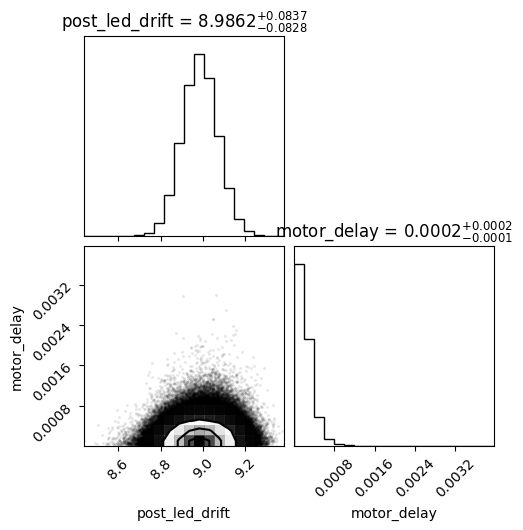

In [31]:
import corner
vp_samples = vp.sample(int(1e6))[0]
post_led_drift_samp = vp_samples[:, 0]
motor_delay_samp = vp_samples[:, 1]

# combined_samples = np.transpose(np.vstack((base_V_A_samp, theta_A_samp, t_A_aff_samp)))
# param_labels = ['base_V_A', 'theta_A', 't_A_aff']

combined_samples = np.transpose(np.vstack((post_led_drift_samp, motor_delay_samp)))
param_labels = ['post_led_drift', 'motor_delay']

corner.corner (combined_samples, labels=param_labels, show_titles=True, title_fmt=".4f");


In [39]:
post_LED_drift_mean = np.mean(post_led_drift_samp)
motor_delay_mean = np.mean(motor_delay_samp)

# abort rate with this new params

In [32]:
# df_led_on = df_led_on[df_led_on['abort_event'] == 3 | df_led_on['success'].isin([1,-1])]
df_led_on_aborts = df_led_on[df_led_on['abort_event'] == 3]
# remove aborts < .3
df_led_on_aborts = df_led_on_aborts[df_led_on_aborts['timed_fix'] > 0.3]

In [150]:

def PA_with_LEDON_2_VEC_DEBUG(t, v, vON, a, tfix, tled, delta_i, delta_m):
    """
    Compute the PA pdf by combining contributions before and after LED onset (vectorized).

    Parameters:
        t (numpy.ndarray): Time values.
        v (float): Drift parameter before LED.
        vON (float): Drift parameter after LED onset.
        a (float): Decision bound.
        tfix (float): Fixation time.
        tled (float): LED time.
        delta_A (float): Delta parameter.

    Returns:
        numpy.ndarray: The combined PA pdf values.
    """
    t = np.asarray(t)
    result = np.zeros_like(t)
    
    before_led = (t + tfix) <= (tled + 1e-6)
    result[before_led] = d_A_RT_VEC(v * a, (t[before_led] - (delta_i + delta_m) + tfix) / (a**2)) / (a**2)
    
    # Compute the time difference for the post-LED condition
    t_post_led = t[~before_led] + tfix - delta_m - tled
    tp_post_led = tled + tfix - delta_i

    # Mask for valid time points (ensuring t_post_led is non-negative)
    valid_indices = t_post_led >= 0
    
    # Compute only for valid indices
    result[~before_led][valid_indices] = stupid_f_integral_VEC(v, vON, a, t_post_led[valid_indices], tp_post_led)

    if np.any(t_post_led == 0):
        print(f't_post_led contains zero values')
        # find idx of t_post_led == 0
        idx = np.where(t_post_led == 0)
        t_zero = t[~before_led][idx]
        print(f't ={t_zero}, delta m = {delta_m}, tled = {tled}, tfix = {tfix}, together = {t[~before_led]},{tfix - delta_m - tled}')
    return result

In [155]:
N_theory = int(1e3)
t_pts = np.arange(0, 2, 0.005)

P_A_samples = np.zeros((N_theory, len(t_pts)))
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]

delta_i = total_proactive_delay - motor_delay_mean
# sample N_theory indices
indices = np.random.choice(len(df_led_on_aborts), N_theory)

for i in tqdm(range(N_theory)):
# for i in tqdm(range(10)):

    _, t_LED = t_stim_and_led_tuple[indices[i]]
    # P_A_samp = PA_with_LEDON_2_VEC(t_pts, V_A, post_LED_drift_mean, theta_A, 0, t_LED, delta_i, motor_delay_mean)
    P_A_samp = PA_with_LEDON_2_VEC_DEBUG(t_pts, V_A, 2.53, theta_A, 0, t_LED, -0.22, 0.0405)

P_A_samp_mean = np.mean(P_A_samples, axis=0)

100%|██████████| 1000/1000 [00:00<00:00, 11035.96it/s]


Text(0.5, 1.0, '75513')

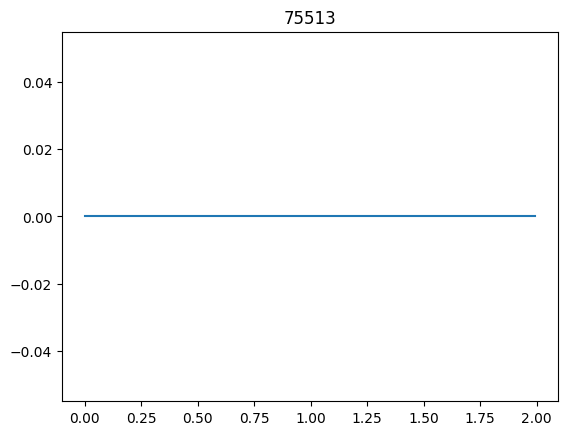

In [170]:
r = np.random.choice(len(t_stim_and_led_tuple))
t_stim, t_LED = t_stim_and_led_tuple[r]
# P_A_samp = PA_with_LEDON_2_VEC(t_pts, V_A, post_LED_drift_mean, theta_A, t_stim, t_LED, delta_i, motor_delay_mean)
P_A_samp = PA_with_LEDON_2_VEC_DEBUG(t_pts, V_A, 2.53, theta_A, t_stim, t_LED, -0.22, 0.0401)
plt.plot(t_pts, P_A_samp, label='sampled')
plt.title(r)

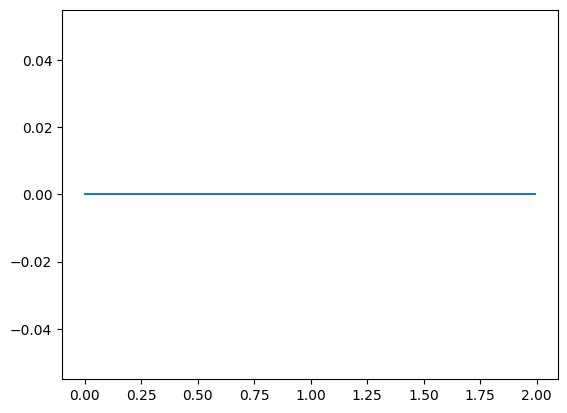

In [45]:
plt.plot(t_pts, P_A_samp_mean, label='mean')

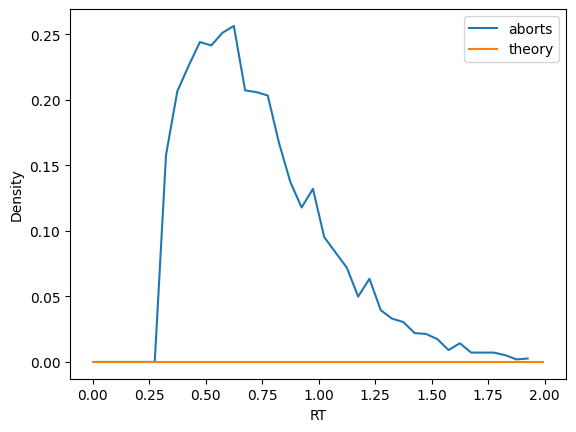

In [42]:
# wrt fixation
frac_aborts = len(df_led_on_aborts) / len(df_led_on)
df_led_on_aborts_rt = df_led_on_aborts['timed_fix']
bins = np.arange(0, 2, 0.05)
aborts_hist, _ = np.histogram(df_led_on_aborts_rt, bins=bins, density=True)
aborts_hist *= frac_aborts
bin_centers = (bins[1:] + bins[:-1]) / 2
plt.plot(bin_centers, aborts_hist, label='aborts')
plt.plot(t_pts, P_A_samp_mean, label='theory')
plt.xlabel('RT')
plt.ylabel('Density')
plt.legend()